## Problem Statement
* Analysis the effects of markdown on holidays.
* Predict sales for the next year.

Source of dataset:
Kaggle.com

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

import warnings
warnings.filterwarnings('ignore')

### Sales dataset Analysis

In [3]:
sales = pd.read_csv(r"C:\Users\mansi\Advance Big data\Assignment 3\Retail_data\sales data-set.csv")
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,5/2/2010,24924.50,False
1,1,1,12/2/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,5/3/2010,21827.90,False


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Date']

0        2010-05-02
1        2010-12-02
2        2010-02-19
3        2010-02-26
4        2010-05-03
            ...    
421565   2012-09-28
421566   2012-05-10
421567   2012-12-10
421568   2012-10-19
421569   2012-10-26
Name: Date, Length: 421570, dtype: datetime64[ns]

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [7]:
sales['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [8]:
# Having seperate column for year of sales for yearly calculations
sales['Year_of_Sales']= sales['Date'].dt.year
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year_of_Sales
0,1,1,2010-05-02,24924.50,False,2010
1,1,1,2010-12-02,46039.49,True,2010
2,1,1,2010-02-19,41595.55,False,2010
3,1,1,2010-02-26,19403.54,False,2010
4,1,1,2010-05-03,21827.90,False,2010


### Department 92 is having comparetively high sales in some of the stores.

In [9]:
sales_by_year= sales.groupby(['Store', 'Dept','Year_of_Sales'])['Weekly_Sales'].mean().sort_values(ascending=False)
sales_by_year.head(20)

Store  Dept  Year_of_Sales
14     92    2010             191087.146458
             2011             185184.011154
13     92    2012             174680.923721
20     92    2012             173169.219302
4      92    2012             170885.785116
2      92    2012             170083.332326
14     92    2012             169761.537209
20     92    2011             165298.795000
2      92    2011             163993.668269
13     92    2011             163212.083654
4      92    2011             161636.947115
2      92    2010             161060.395625
4      95    2012             159481.987209
14     95    2010             158140.568958
10     72    2010             156366.184583
20     92    2010             156266.901458
       95    2010             152945.078542
             2012             152726.156977
27     92    2010             150686.671458
10     72    2011             149950.116346
Name: Weekly_Sales, dtype: float64

### Features dataset

In [10]:
features = pd.read_csv(r"C:\Users\mansi\Advance Big data\Assignment 3\Retail_data\Features data set.csv")
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,5/2/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/2/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,5/3/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,5/7/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/7/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [12]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [13]:
features['Date'] = pd.to_datetime(features['Date'])
features['Date']

0      2010-05-02
1      2010-12-02
2      2010-02-19
3      2010-02-26
4      2010-05-03
          ...    
8185   2013-06-28
8186   2013-05-07
8187   2013-12-07
8188   2013-07-19
8189   2013-07-26
Name: Date, Length: 8190, dtype: datetime64[ns]

### Stores dataset analysis

In [14]:
stores = pd.read_csv(r"C:\Users\mansi\Advance Big data\Assignment 3\Retail_data\stores data-set.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [15]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [16]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


### Merging Dataset

In [17]:
df=pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df=pd.merge(df,stores, on=['Store'], how='left')

df=df.fillna(0)

In [18]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['Type']= label_encoder.fit_transform(df['Type'])
df['Type'].unique()

array([0, 1, 2])

In [19]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year_of_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0,151315
1,1,1,2010-12-02,46039.49,True,2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0,151315
2,1,1,2010-02-19,41595.55,False,2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0,151315
3,1,1,2010-02-26,19403.54,False,2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0,151315
4,1,1,2010-05-03,21827.90,False,2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,1,118221
421566,45,98,2012-05-10,628.10,False,2012,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,1,118221
421567,45,98,2012-12-10,1061.02,False,2012,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,1,118221
421568,45,98,2012-10-19,760.01,False,2012,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,1,118221


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          421570 non-null  int64         
 1   Dept           421570 non-null  int64         
 2   Date           421570 non-null  datetime64[ns]
 3   Weekly_Sales   421570 non-null  float64       
 4   IsHoliday      421570 non-null  bool          
 5   Year_of_Sales  421570 non-null  int64         
 6   Temperature    421570 non-null  float64       
 7   Fuel_Price     421570 non-null  float64       
 8   MarkDown1      421570 non-null  float64       
 9   MarkDown2      421570 non-null  float64       
 10  MarkDown3      421570 non-null  float64       
 11  MarkDown4      421570 non-null  float64       
 12  MarkDown5      421570 non-null  float64       
 13  CPI            421570 non-null  float64       
 14  Unemployment   421570 non-null  float64       
 15  

In [21]:
col_list= ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
# sum specific columns
df['Sum'] = df[col_list].mean(axis=1)
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year_of_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Sum
0,1,1,2010-05-02,24924.50,False,2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0,151315,0.000
1,1,1,2010-12-02,46039.49,True,2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0,151315,0.000
2,1,1,2010-02-19,41595.55,False,2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0,151315,0.000
3,1,1,2010-02-26,19403.54,False,2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0,151315,0.000
4,1,1,2010-05-03,21827.90,False,2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0,151315,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,1,118221,1893.602
421566,45,98,2012-05-10,628.10,False,2012,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,1,118221,1931.800
421567,45,98,2012-12-10,1061.02,False,2012,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,1,118221,1310.806
421568,45,98,2012-10-19,760.01,False,2012,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,1,118221,796.484


In [22]:
df['day_name'] = pd.to_datetime(df['Date']).dt.day_name()
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year_of_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Sum,day_name
0,1,1,2010-05-02,24924.50,False,2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0,151315,0.000,Sunday
1,1,1,2010-12-02,46039.49,True,2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0,151315,0.000,Thursday
2,1,1,2010-02-19,41595.55,False,2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0,151315,0.000,Friday
3,1,1,2010-02-26,19403.54,False,2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0,151315,0.000,Friday
4,1,1,2010-05-03,21827.90,False,2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0,151315,0.000,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,1,118221,1893.602,Friday
421566,45,98,2012-05-10,628.10,False,2012,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,1,118221,1931.800,Thursday
421567,45,98,2012-12-10,1061.02,False,2012,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,1,118221,1310.806,Monday
421568,45,98,2012-10-19,760.01,False,2012,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,1,118221,796.484,Friday


array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'Dept'}>,
        <AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>],
       [<AxesSubplot:title={'center':'Year_of_Sales'}>,
        <AxesSubplot:title={'center':'Temperature'}>,
        <AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'MarkDown1'}>],
       [<AxesSubplot:title={'center':'MarkDown2'}>,
        <AxesSubplot:title={'center':'MarkDown3'}>,
        <AxesSubplot:title={'center':'MarkDown4'}>,
        <AxesSubplot:title={'center':'MarkDown5'}>],
       [<AxesSubplot:title={'center':'CPI'}>,
        <AxesSubplot:title={'center':'Unemployment'}>,
        <AxesSubplot:title={'center':'Type'}>,
        <AxesSubplot:title={'center':'Size'}>],
       [<AxesSubplot:title={'center':'Sum'}>,
        <AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Da

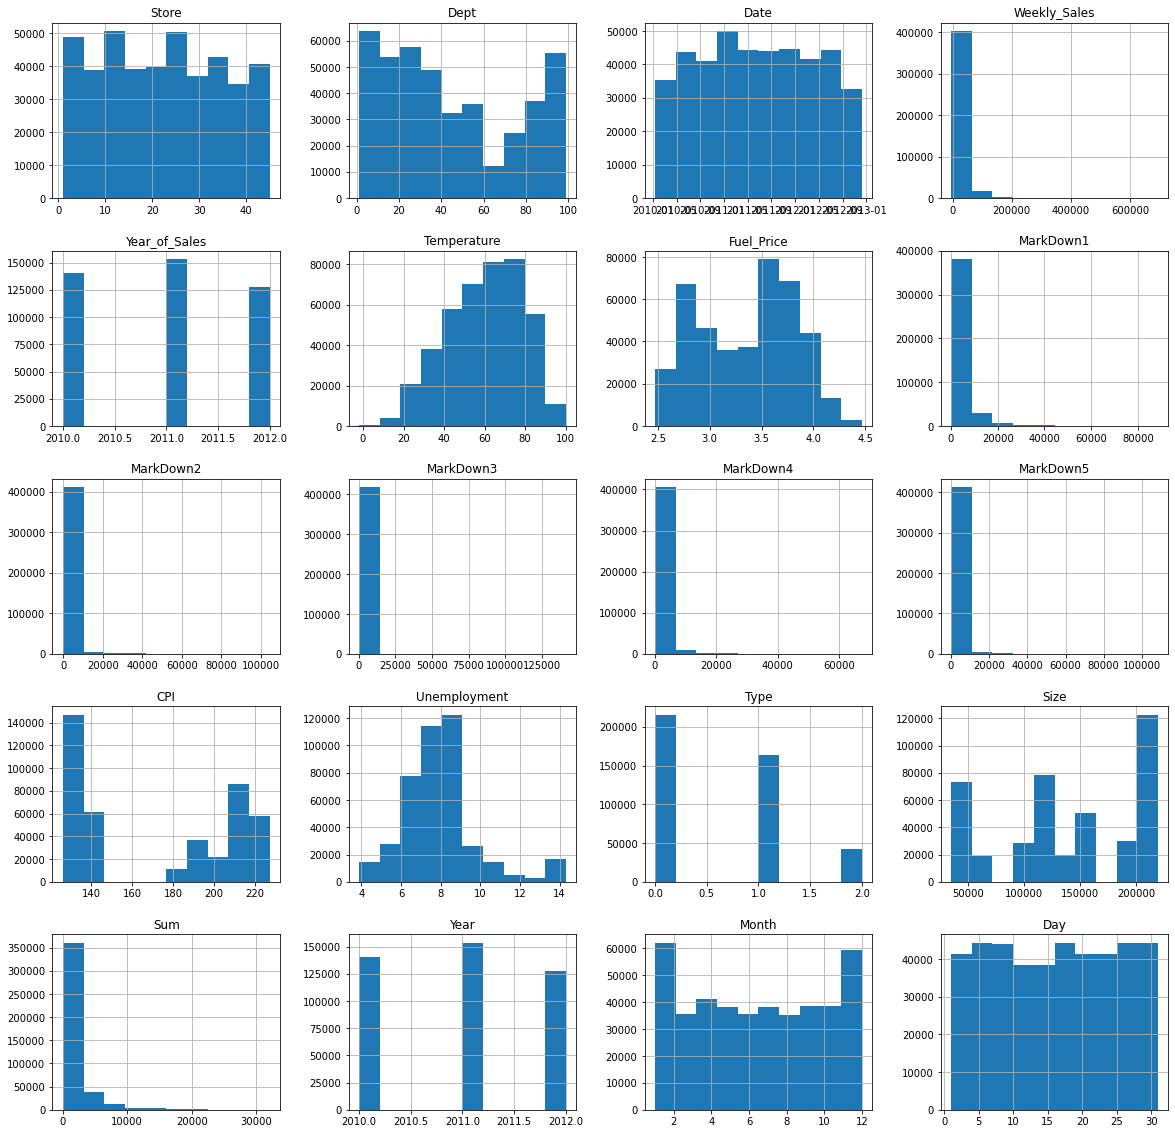

In [36]:
df.hist(figsize = (20,20))

In [23]:
holiday_markdown = df[['Store','Date','Weekly_Sales','IsHoliday','Sum','day_name']]
holiday_markdown

,Store,Date,Weekly_Sales,IsHoliday,Sum,day_name
0,1,2010-05-02,24924.50,False,0.000,Sunday
1,1,2010-12-02,46039.49,True,0.000,Thursday
2,1,2010-02-19,41595.55,False,0.000,Friday
3,1,2010-02-26,19403.54,False,0.000,Friday
4,1,2010-05-03,21827.90,False,0.000,Monday
...,...,...,...,...,...,...
421565,45,2012-09-28,508.37,False,1893.602,Friday
421566,45,2012-05-10,628.10,False,1931.800,Thursday
421567,45,2012-12-10,1061.02,False,1310.806,Monday
421568,45,2012-10-19,760.01,False,796.484,Friday


## Highest sales is done on black friday in year 2010 in store 10 with markdown 0

In [24]:
holiday_markdown.loc[holiday_markdown['Weekly_Sales'].idxmax()]

Store                            10
Date            2010-11-26 00:00:00
Weekly_Sales              693099.36
IsHoliday                      True
Sum                             0.0
day_name                     Friday
Name: 95373, dtype: object

In [25]:
holiday_markdown.describe()

,Store,Weekly_Sales,Sum
count,421570.000000,421570.000000,421570.000000
mean,22.200546,15981.258123,1336.808287
std,12.785297,22711.183519,2950.188310
min,1.000000,-4988.940000,0.000000
25%,11.000000,2079.650000,0.000000
50%,22.000000,7612.030000,0.000000
75%,33.000000,20205.852500,1615.052000
max,45.000000,693099.360000,32102.122000


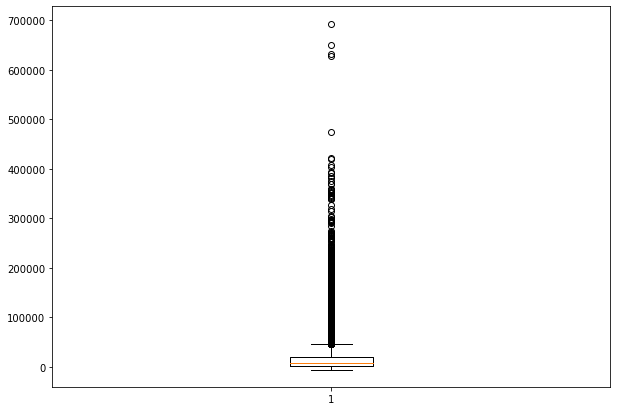

In [26]:
fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.boxplot(holiday_markdown['Weekly_Sales'])
 
# show plot
plt.show()

In [27]:
Holiday = holiday_markdown[holiday_markdown['IsHoliday'] == True]
Holiday

,Store,Date,Weekly_Sales,IsHoliday,Sum,day_name
1,1,2010-12-02,46039.49,True,0.000,Thursday
31,1,2010-10-09,18194.74,True,0.000,Saturday
42,1,2010-11-26,18820.29,True,0.000,Friday
47,1,2010-12-31,19124.58,True,0.000,Friday
53,1,2011-11-02,37887.17,True,0.000,Wednesday
...,...,...,...,...,...,...
421510,45,2011-09-09,1092.66,True,0.000,Friday
421521,45,2011-11-25,794.62,True,5725.278,Friday
421526,45,2011-12-30,553.21,True,9788.160,Friday
421532,45,2012-10-02,770.86,True,6444.322,Tuesday


In [28]:
non_holiday = holiday_markdown[holiday_markdown['IsHoliday'] == False]
non_holiday

,Store,Date,Weekly_Sales,IsHoliday,Sum,day_name
0,1,2010-05-02,24924.50,False,0.000,Sunday
2,1,2010-02-19,41595.55,False,0.000,Friday
3,1,2010-02-26,19403.54,False,0.000,Friday
4,1,2010-05-03,21827.90,False,0.000,Monday
5,1,2010-12-03,21043.39,False,0.000,Friday
...,...,...,...,...,...,...
421565,45,2012-09-28,508.37,False,1893.602,Friday
421566,45,2012-05-10,628.10,False,1931.800,Thursday
421567,45,2012-12-10,1061.02,False,1310.806,Monday
421568,45,2012-10-19,760.01,False,796.484,Friday


### In store 10 and 35, maximum sale is on holidays

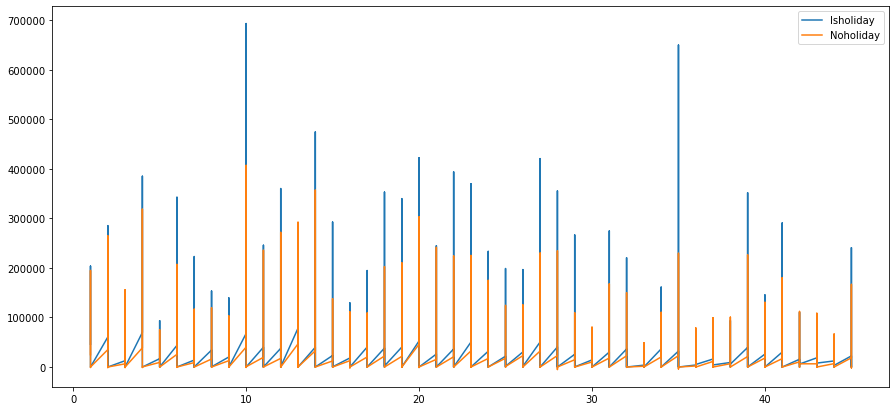

In [29]:
plt.figure(figsize=(15,7))

plt.plot(Holiday['Store'], Holiday['Weekly_Sales'], label = "Isholiday")
plt.plot(non_holiday['Store'], non_holiday['Weekly_Sales'],label = "Noholiday")
plt.legend()
plt.show()

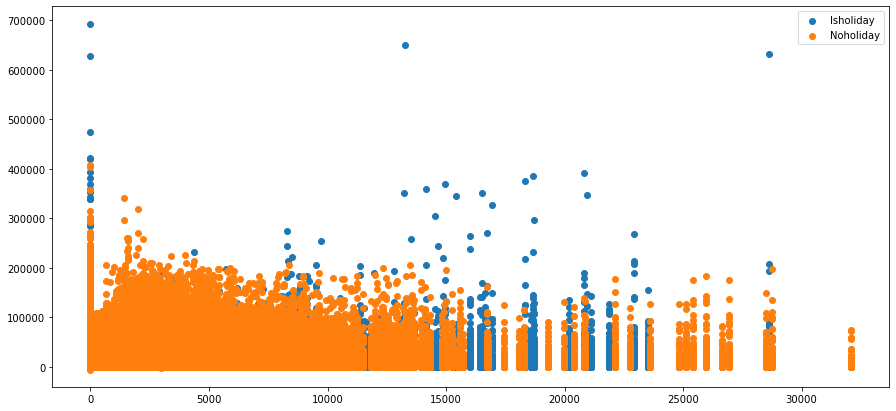

In [30]:
plt.figure(figsize=(15,7))

plt.scatter(Holiday['Sum'], Holiday['Weekly_Sales'], label = "Isholiday")
plt.scatter( non_holiday['Sum'], non_holiday['Weekly_Sales'],label = "Noholiday")
plt.legend()
plt.show()

In [31]:
df['Year'] = df.Date.apply(lambda x: int(str(x)[:4]))
df['Month'] = df.Date.apply(lambda x: int(str(x)[5:7]))
df['Year-Month'] = df.Date.apply(lambda x: str(x)[:7])
df['Day'] = df.Date.apply(lambda x: int(str(x)[8:10]))

### there was drastic increase in fuel price in the month of january,2010 after that it has been fluctuating along the same line 

Text(0.5, 1.0, 'LinePlot showing the change in fuel price over the span of 3 years')

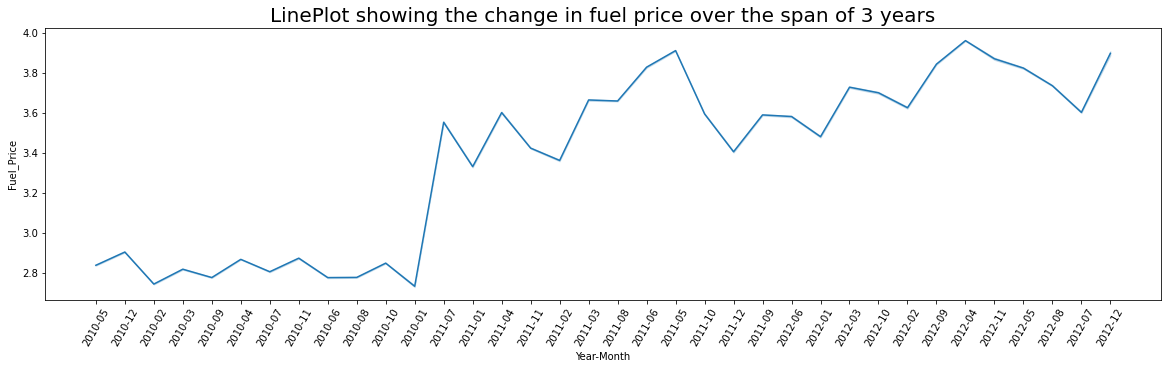

In [105]:
plt.subplots(figsize = (20,5))
plt.xticks(rotation = 60)
sns.lineplot(data = df, x = 'Year-Month',y = 'Fuel_Price')
plt.title('LinePlot showing the change in fuel price over the span of 3 years', fontsize=20)

### Datevise tracking of all the variables

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

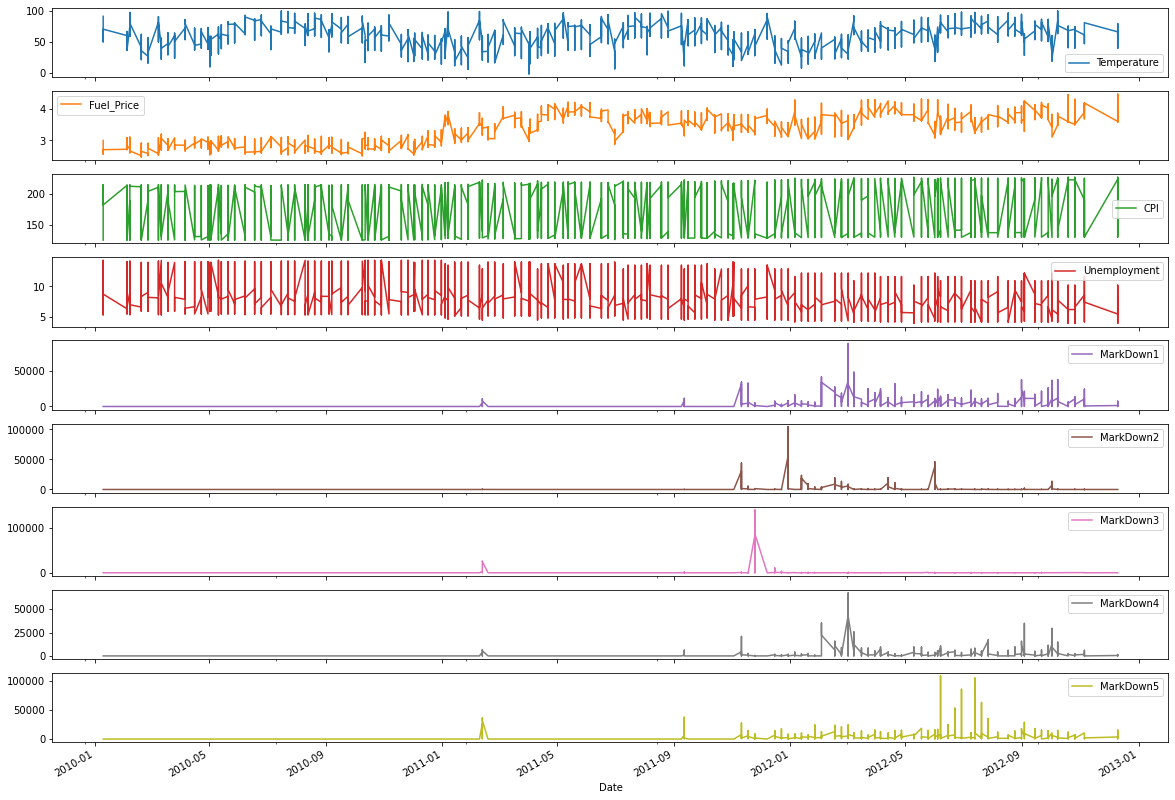

In [114]:
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x = 'Date', subplots = True, figsize = (20,15))

### To check how normally the date is collected during each month of all the 3 years

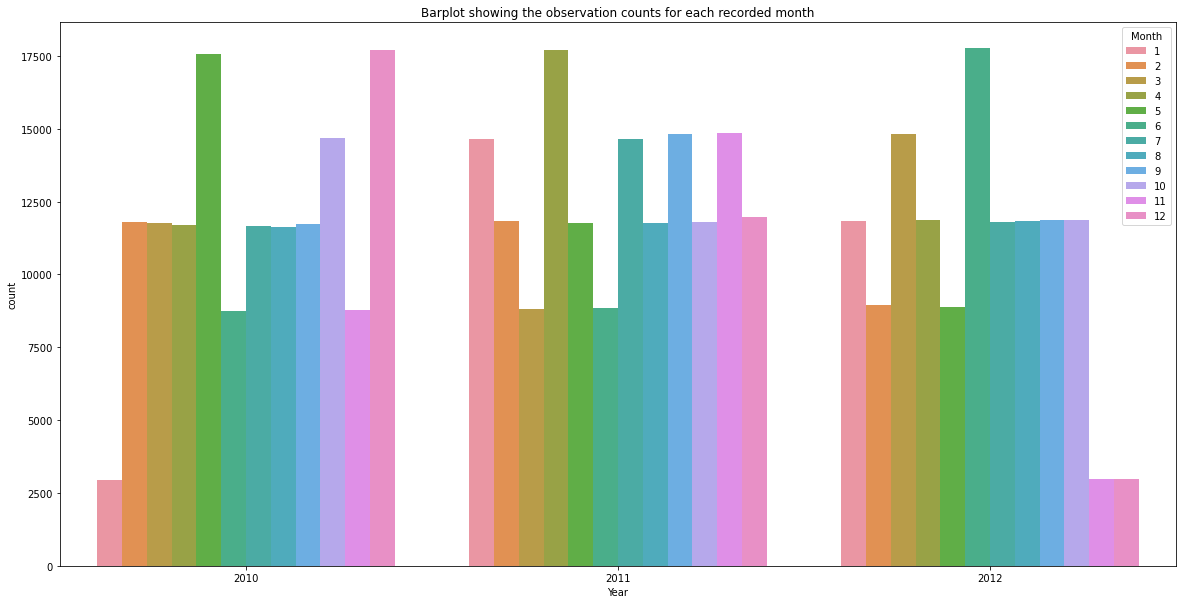

In [110]:
plt.subplots(figsize = (20,10))
sns.countplot(data = df,x='Year',hue='Month')
plt.title('Barplot showing the observation counts for each recorded month')

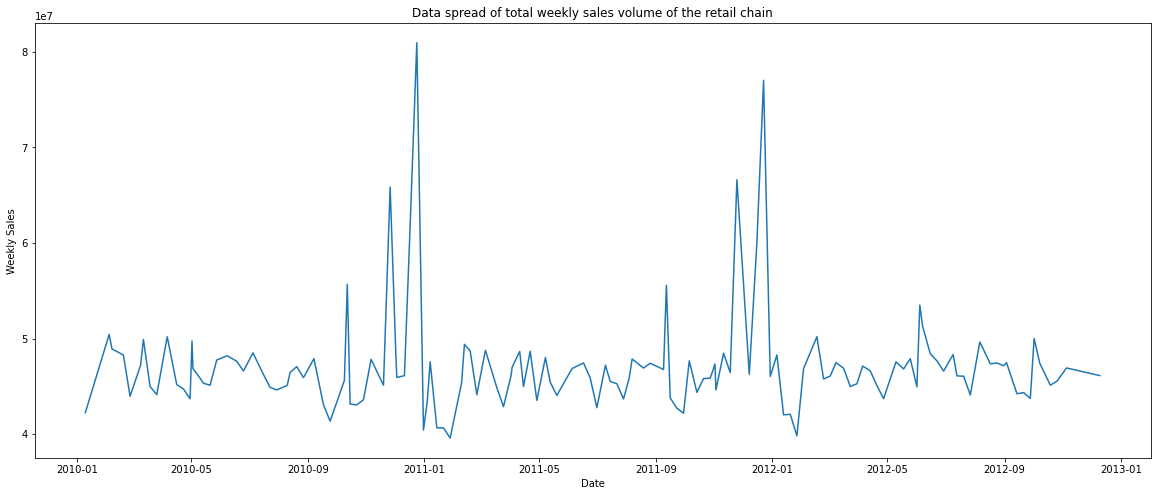

In [115]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,8))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.title('Data spread of total weekly sales volume of the retail chain')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

### We can conclude from the graph that maximun sales happens on friday

In [43]:
df_droped = df.drop(df[df.day_name == 'Friday'].index)
df_droped.shape

(138586, 23)

Text(0, 0.5, 'Weekly Sales')

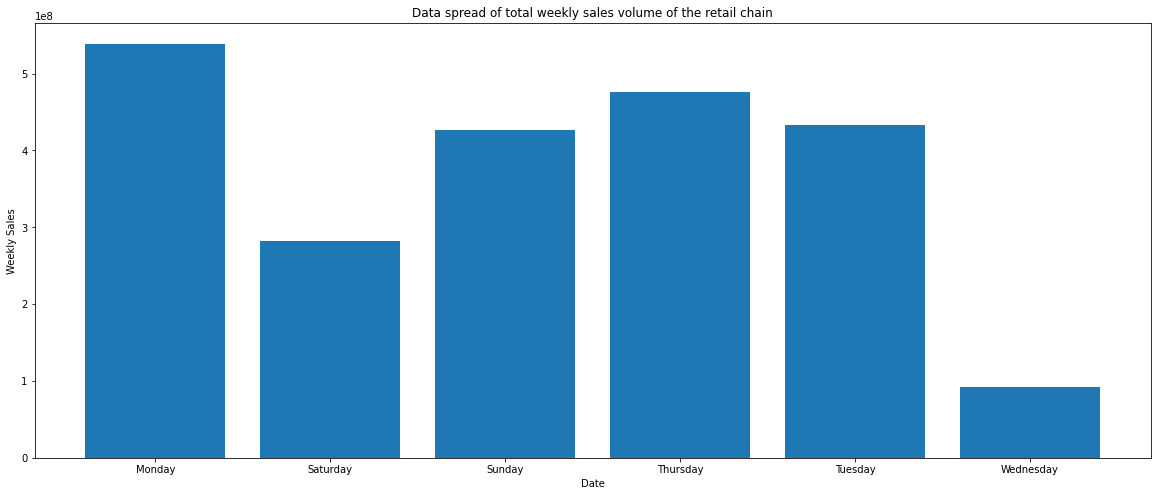

In [44]:
df_average_sales_week = df_droped.groupby(by=['day_name'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,8))
plt.bar(df_average_sales_week.day_name, df_average_sales_week.Weekly_Sales)
plt.title('Data spread of total weekly sales volume of the retail chain')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

Text(0, 0.5, 'Weekly Sales')

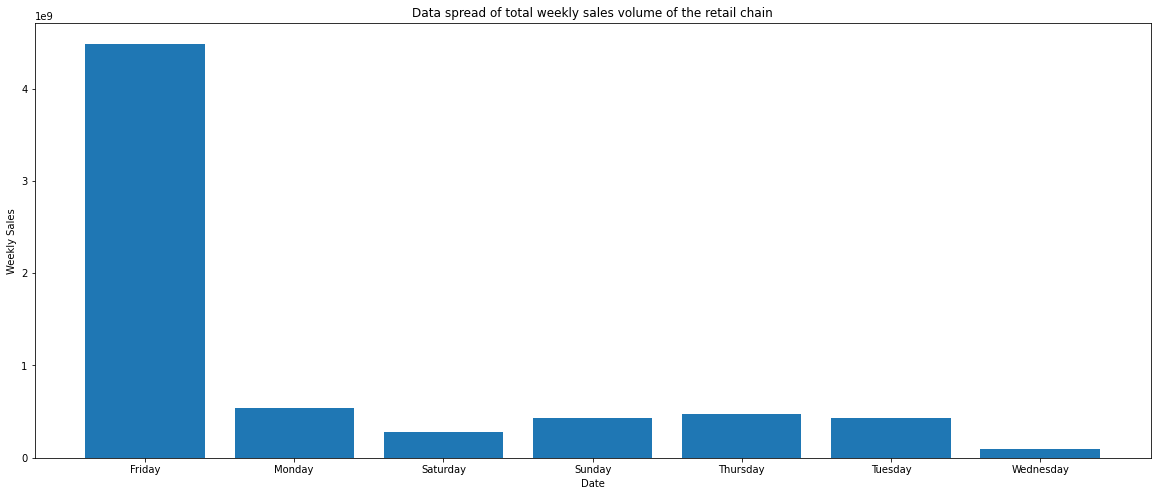

In [45]:
df_average_sales_week = df.groupby(by=['day_name'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

plt.figure(figsize=(20,8))
plt.bar(df_average_sales_week.day_name, df_average_sales_week.Weekly_Sales)
plt.title('Data spread of total weekly sales volume of the retail chain')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

### Department from 90-100 have maximum sales 

In [118]:
data_Dept = df.groupby("Dept").agg({"Weekly_Sales":"sum"})
data_Dept.Weekly_Sales = data_Dept.Weekly_Sales/10000
data_Dept.Weekly_Sales = data_Dept.Weekly_Sales.apply(int)
data_Dept.sort_values(by="Weekly_Sales")

,Weekly_Sales
Dept,
39,0
78,0
43,0
47,0
51,3
...,...
90,29106
72,30572
38,39311


Text(0.5, 0, 'Department')

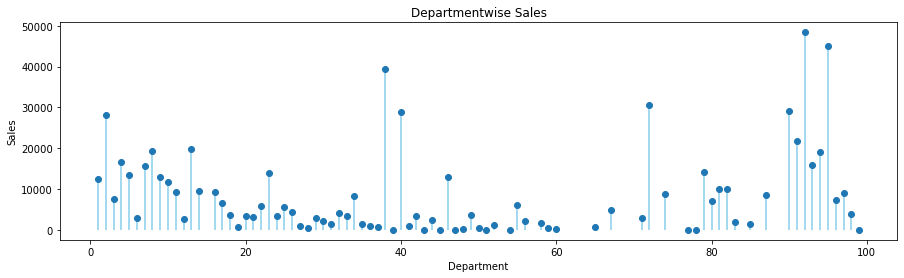

In [119]:
# departmentwise
fig1, ax1 = plt.subplots(figsize=(15, 4))
#ordered_df = data_Dept.sort_values(by='Weekly_Sales')
plt.vlines(x=data_Dept.index, ymin=0, ymax=data_Dept['Weekly_Sales'], color='skyblue')
plt.plot(data_Dept.index,data_Dept['Weekly_Sales'], "o")
plt.title("Departmentwise Sales")
plt.ylabel("Sales")
plt.xlabel("Department")

### Predicting dept wise sales

In [121]:
data = df[['Store','Dept','Date','Weekly_Sales','IsHoliday','Year_of_Sales','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type']]
data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year_of_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type
0,1,1,2010-05-02,24924.50,False,2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0
1,1,1,2010-12-02,46039.49,True,2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0
2,1,1,2010-02-19,41595.55,False,2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0
3,1,1,2010-02-26,19403.54,False,2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0
4,1,1,2010-05-03,21827.90,False,2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2012,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,1
421566,45,98,2012-05-10,628.10,False,2012,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,1
421567,45,98,2012-12-10,1061.02,False,2012,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,1
421568,45,98,2012-10-19,760.01,False,2012,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,1


### Linear Regression Model

In [123]:
predictors = ['Store','Dept','IsHoliday','Year_of_Sales','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type']
outcome = 'Weekly_Sales'

# Partition data into both train and test data
#
X = df[predictors]
y = df[outcome]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.40, random_state=9)

# Build the linear regression model
#
sales_lm_s = LinearRegression()
sales_lm_s.fit(train_X, train_y)

# Regression coefficients
#
print('intercept ', sales_lm_s.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': sales_lm_s.coef_}))

# Accuracy Metrics for the Regression Model
#
# Performance measures
#RSME as low as possible is good.
regressionSummary(train_y, sales_lm_s.predict(train_X))

intercept  4118515.2317735404
        Predictor  coefficient
0           Store  -102.643072
1            Dept   112.174251
2       IsHoliday   516.091322
3   Year_of_Sales -2041.165354
4     Temperature    17.759140
5      Fuel_Price  1827.929501
6       MarkDown1     0.109035
7       MarkDown2     0.026135
8       MarkDown3     0.130492
9       MarkDown4     0.028308
10      MarkDown5     0.194546
11            CPI   -23.803514
12   Unemployment  -133.908399
13           Type -5517.083251

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 22151.8095
     Mean Absolute Error (MAE) : 14883.3086


### Residual Analysis

In [124]:
# Use predict() to make predictions on a new set
sales_lm_s_pred = sales_lm_s.predict(test_X)

result = pd.DataFrame({'Predicted': sales_lm_s_pred, 'Actual': test_y, 'Residual': test_y - sales_lm_s_pred})
print(result.head(10))

# Accuracy measures
regressionSummary(test_y, sales_lm_s_pred)

           Predicted    Actual      Residual
52380   18432.660529   6800.58 -11632.080529
294620  12664.910986  18810.22   6145.309014
308043  15877.607313   3007.80 -12869.807313
124406  37090.263003    145.12 -36945.143003
374861  17642.727014   2645.96 -14996.767014
39748   27591.348847      8.98 -27582.368847
161931  13865.084333   4047.08  -9818.004333
74668   19016.140832  19220.73    204.589168
212386  14499.850699   1087.50 -13412.350699
219462  11600.401447   9976.17  -1624.231447

Regression statistics

               Mean Error (ME) : -181.8995
Root Mean Squared Error (RMSE) : 21730.5736
     Mean Absolute Error (MAE) : 14747.0636


Percentage 0.05516877386910833
255558    41197.385636
292779    40427.043367
255781    52974.057829
169083    34687.824890
178228    25482.636442
              ...     
242208    38626.570843
90590     38832.663932
113122    36014.436357
242196    27302.838484
197034    36628.650676
Name: Weekly_Sales, Length: 17244, dtype: float64


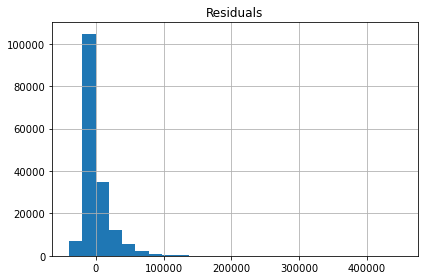

In [127]:
sales_lm_s_pred = sales_lm_s.predict(test_X)
all_residuals = test_y - sales_lm_s_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print('Percentage', len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))
print(all_residuals[(all_residuals > 25000)])

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)
plt.tight_layout()
plt.show()

### Backward Elimination of predictors

In [129]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Store, Dept, IsHoliday, Year_of_Sales, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Type
Start: score=5779560.92
Step: score=5779560.68, remove MarkDown4
Step: score=5779560.68, remove None
['Store', 'Dept', 'IsHoliday', 'Year_of_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5', 'CPI', 'Unemployment', 'Type']


In [130]:
regressionSummary(test_y, best_model.predict(test_X[best_variables]))


Regression statistics

               Mean Error (ME) : -181.7302
Root Mean Squared Error (RMSE) : 21730.2001
     Mean Absolute Error (MAE) : 14746.7798


### Forward Selection of predictors

In [131]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Store, Dept, IsHoliday, Year_of_Sales, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Type
Start: score=5795951.61, constant
Step: score=5787558.11, add Type
Step: score=5781721.06, add Dept
Step: score=5781064.85, add Store
Step: score=5780550.31, add CPI
Step: score=5780246.94, add MarkDown3
Step: score=5780017.06, add MarkDown5
Step: score=5779892.83, add Year_of_Sales
Step: score=5779744.86, add MarkDown1
Step: score=5779625.32, add Fuel_Price
Step: score=5779597.96, add Temperature
Step: score=5779576.40, add Unemployment
Step: score=5779566.39, add IsHoliday
Step: score=5779560.68, add MarkDown2
Step: score=5779560.68, add None
['Type', 'Dept', 'Store', 'CPI', 'MarkDown3', 'MarkDown5', 'Year_of_Sales', 'MarkDown1', 'Fuel_Price', 'Temperature', 'Unemployment', 'IsHoliday', 'MarkDown2']


In [132]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Store, Dept, IsHoliday, Year_of_Sales, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Type
Start: score=5795951.61, constant
Step: score=5787558.11, add Type
Step: score=5781721.06, add Dept
Step: score=5781064.85, add Store
Step: score=5780550.31, add CPI
Step: score=5780246.94, add MarkDown3
Step: score=5780017.06, add MarkDown5
Step: score=5779892.83, add Year_of_Sales
Step: score=5779744.86, add MarkDown1
Step: score=5779625.32, add Fuel_Price
Step: score=5779597.96, add Temperature
Step: score=5779576.40, add Unemployment
Step: score=5779566.39, add IsHoliday
Step: score=5779560.68, add MarkDown2
Step: score=5779560.68, unchanged None
['Type', 'Dept', 'Store', 'CPI', 'MarkDown3', 'MarkDown5', 'Year_of_Sales', 'MarkDown1', 'Fuel_Price', 'Temperature', 'Unemployment', 'IsHoliday', 'MarkDown2']


### Ridge Linear Regression

In [133]:
print('\nRidge')
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(test_y, ridge.predict(test_X))

print('\n\nRidge coefficients', ridge.coef_)


Ridge

Regression statistics

               Mean Error (ME) : -168.9340
Root Mean Squared Error (RMSE) : 21898.5170
     Mean Absolute Error (MAE) : 14766.4377


Ridge coefficients [-6.20078861e+01  5.58424194e+01  3.71740418e+02 -4.25222501e+02
  4.53038450e+00  6.38805980e+01  4.96748445e-02  1.71806581e-02
  7.20342506e-02  5.48394258e-02  9.78885625e-02 -1.06927871e+01
 -6.24553115e+01 -2.88499634e+03]


### Lasso and LassoCV linear regression

In [136]:
print('\nLasso')
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regressionSummary(test_y, lasso.predict(test_X))

print('\n\nLasso coefficients', lasso.coef_)

print('\n')
print(lasso.predict(test_X))

print('\n\nLasso Cross-Validation')
lasso_cv = LassoCV(normalize=True, cv=100)
lasso_cv.fit(train_X, train_y)
regressionSummary(test_y, lasso_cv.predict(test_X))

print('\n\nLasso-CV chosen regularization: ', lasso_cv.alpha_)
print('\n')
print(lasso_cv.predict(test_X))


Lasso

Regression statistics

               Mean Error (ME) : -173.0863
Root Mean Squared Error (RMSE) : 21773.7493
     Mean Absolute Error (MAE) : 14748.7043


Lasso coefficients [-6.42602784e+01  9.54059243e+01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.18068683e-03  0.00000000e+00
  5.13536436e-02  0.00000000e+00  4.60263264e-02 -1.00521384e+01
  0.00000000e+00 -5.16638879e+03]


[17961.8018014  14436.12789283 16869.71997592 ... 16070.33882624
 11374.12077964 13595.67512844]


Lasso Cross-Validation

Regression statistics

               Mean Error (ME) : -181.7999
Root Mean Squared Error (RMSE) : 21730.4587
     Mean Absolute Error (MAE) : 14746.4871


Lasso-CV chosen regularization:  0.008220777561261192


[18423.4087691  12676.54300153 15883.08359526 ... 15803.56308478
 11139.89920835 14338.41497952]


## Conclusion
#### Analysis from statistics 
* Based on the statistical analysis we can conclude that maximum sales happen on friday even after removing some of the outliers like black friday. 
* The second next important day is monday , based on this store can plan their marketing strategy and promotions.

#### Analysis from graph
* On non-holiday days, people do shop if markdown is between 0 and 15000.
* The department 90-100 has maximum sales, store can focus on the marekting of this department.

#### Analysis from predicting model 
* Lasso cross-validation regression model is showing the minimum RSME, so this is the most reliable model to predict next year sales.